### Initial settings

In [2]:
#-- Import general libraries
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices # Comment out this line if runing on GPU cluster
import numpy as np 
import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import wandb

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{2}"

In [4]:
# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(f"Is GPU available? {is_gpu}")

# If GPU is available, print additional information
if is_gpu:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"GPU Device Name: {device_name}")
    print(f"GPU Device Index: {current_device}")

Is GPU available? True
GPU Device Name: GeForce RTX 2080 Ti
GPU Device Index: 0


#### Filters

In [5]:
# # # ################################### # # #
# # # ######   Numerial parameters ###### # # #
# # # ################################### # # #
c = 1  # speed of sound 1m/s
courant_number = 0.1

# # # ################################### # # #
# # # ######    Linear Filter      ###### # # #
# # # ################################### # # #




filter = torch.tensor([[0.0, -1.0, 0.0],
       [-1.0, 4.0, -1.0],
       [0.0, -1.0, 0.0]])



advection_operator_x = torch.tensor([[0.0, 0.0, 0.0],
       [0.5, 0.0, -0.5],
       [0.0, 0.0, 0.0]])

advection_operator_y = torch.tensor([[0.0, -0.5, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.5, 0.0]])

print(filter)
print(filter.shape)

tensor([[ 0., -1.,  0.],
        [-1.,  4., -1.],
        [ 0., -1.,  0.]])
torch.Size([3, 3])


##### 7*7 Cubic

In [6]:
# 7*7
data_str = """-1.0975826519729831E-003   6.6388197653750505E-003  -3.1874333451830800E-002   4.1414859580519367E-003  -3.1874333451830786E-002   6.6388197653750435E-003  -1.0975826519729816E-003
 6.6388197653750505E-003  -3.4553857092072565E-002  0.13605581230003569       0.18684678279416977       0.13605581230003563       -3.4553857092072537E-002   6.6388197653750418E-003
-3.1874333451830800E-002  0.13605581230003572      -0.35093761109136207       -2.0260398151439736      -0.35093761109136201       0.13605581230003563       -3.1874333451830779E-002
 4.1414859580518951E-003  0.18684678279416983       -2.0260398151439745        8.0000000000000000       -2.0260398151439745       0.18684678279416983        4.1414859580518951E-003
-3.1874333451830786E-002  0.13605581230003563      -0.35093761109136201       -2.0260398151439736      -0.35093761109136201       0.13605581230003569       -3.1874333451830800E-002
 6.6388197653750418E-003  -3.4553857092072537E-002  0.13605581230003563       0.18684678279416977       0.13605581230003566       -3.4553857092072565E-002   6.6388197653750505E-003
-1.0975826519729816E-003   6.6388197653750435E-003  -3.1874333451830779E-002   4.1414859580519367E-003  -3.1874333451830807E-002   6.6388197653750505E-003  -1.0975826519729831E-003"""

# Convert the string to a 2D NumPy array
data_array = np.array([list(map(float, line.split())) for line in data_str.split('\n')])

# Reshape the array into a 9x9 tensor
tensor = data_array.reshape(7, 7)

# Print the generated tensor
print(tensor)

filter = torch.FloatTensor(tensor*1)

print(filter.shape)

[[-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 4.14148596e-03  1.86846783e-01 -2.02603982e+00  8.00000000e+00
  -2.02603982e+00  1.86846783e-01  4.14148596e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]]
torch.Size([7, 7])


#### New initial conditions - Gaussian Distribution

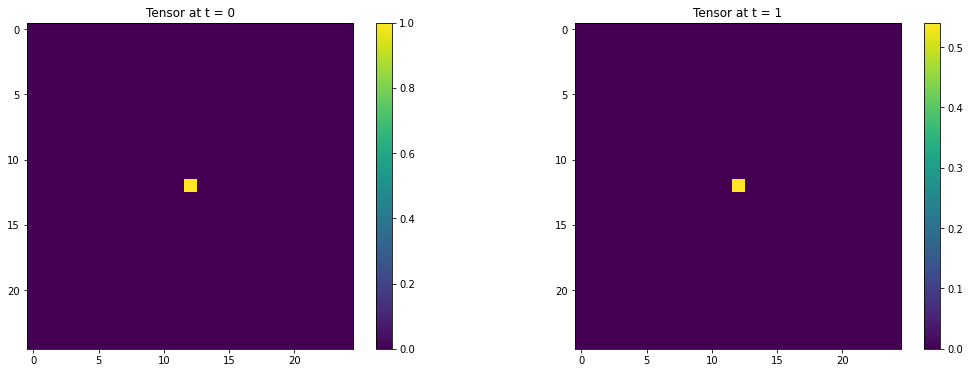

In [7]:
# Specify the size of the tensor
xysize = 25

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Plot the tensors
plt.figure(figsize=(18, 6))

# Plot at t = 0
plt.subplot(1, 2, 1)
plt.imshow(status_t0.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 0')
plt.colorbar()

# Plot at t = 1
plt.subplot(1, 2, 2)
plt.imshow(status_t1.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 1')
plt.colorbar()

# # Plot at t = 2
# plt.subplot(1, 3, 3)
# plt.imshow(status_t2.numpy(), cmap='viridis', interpolation='none')
# plt.title('Tensor at t = 2')
# plt.colorbar()

plt.show()

#### C spead of sound

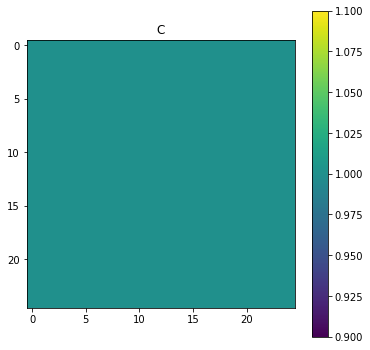

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [8]:
c_np = np.ones((xysize, xysize))

# uncomment to make the values different
# right_half_start = xysize // 2
# c_np[:, right_half_start:] = 2

c = torch.from_numpy(c_np).float().requires_grad_()

# Plot the tensor at t = 0
plt.figure(figsize=(6, 6))
plt.imshow(c.detach().numpy(), cmap='viridis', interpolation='none')
plt.title('C')
plt.colorbar()
plt.show()

c = c.to(device)
print(c)

#### Sigma2

In [9]:
l = xysize/10

In [10]:
value_origin_point = - 9 * (4-0)
k = 400

In [11]:
sigma2 = torch.zeros((xysize, xysize), dtype=torch.float32)

In [12]:
l_over_speed = (l / 1) * 0.05 
print(l_over_speed)

0.125


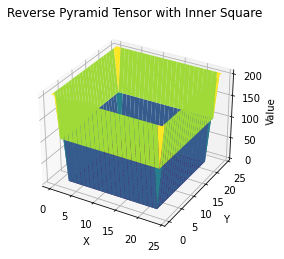

In [13]:
def create_reverse_pyramid_tensor(size, inner_square_ratio):
    pyramid = np.zeros((size, size), dtype=np.float32)

    center = size // 2
    center_value = -16.0/(l_over_speed*l_over_speed)
    boundary_value = 4.0/(l_over_speed*l_over_speed)

    inner_square_width = int(size * inner_square_ratio)

    for i in range(size):
        for j in range(size):
            distance_to_center = max(abs(i - center), abs(j - center))
            
            # Set the values for the reverse pyramid
            pyramid[i, j] = center_value + 4.0/(l_over_speed*l_over_speed) * (distance_to_center/xysize/0.1)
            
            # Set the values for the inner square to 0
            if (
                i >= center - inner_square_width // 2 and i < center + inner_square_width // 2
                and j >= center - inner_square_width // 2 and j < center + inner_square_width // 2
            ):
                pyramid[i, j] = 0.0

    return pyramid

# Set the size of the pyramid (choose an odd number for symmetry)
pyramid_size = 25  # xysize = 25
# inner_square_ratio = 9/10
inner_square_ratio = 4/5

# Create the reverse pyramid tensor with inner square values set to 0
sigma2 = create_reverse_pyramid_tensor(pyramid_size, inner_square_ratio)

# Plot the reverse pyramid tensor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0, pyramid_size, 1)
y = np.arange(0, pyramid_size, 1)
x, y = np.meshgrid(x, y)

ax.plot_surface(x, y, sigma2, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')
ax.set_title('Reverse Pyramid Tensor with Inner Square')

plt.show()

sigma2 = torch.from_numpy(sigma2).to(device)

tensor([[204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000],
        [204.8000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 204.8000],
        [204.8000, 102.4000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000, 102.4000, 204.8000],
        [204.8000, 102.4000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

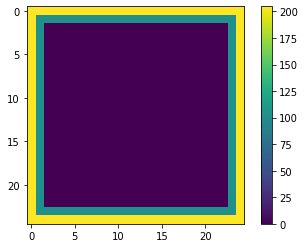

In [14]:
print(sigma2)
plt.imshow(sigma2.detach().cpu().numpy(), cmap='viridis', interpolation='none')
plt.colorbar()

#### ML

In [15]:
ML = torch.ones((1, 1, xysize, xysize), dtype=torch.float64)

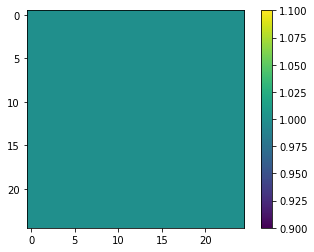

In [16]:
plt.imshow((ML/ML)[0][0].detach().cpu().numpy(), cmap='viridis', interpolation='none')
plt.colorbar()

### Define NN Model

#### Integrated version - one time step

In [17]:
import torch.nn as nn

class AI4WaveNeuralNetwork(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        input_size = (1, 1, xysize, xysize)  # Adjust the size based on your requirements
        batch_size, in_channels, height, width = input_size

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]

        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c, sigma2):
        # Calculate status_tn1 based on the provided expression
        c_status_tn = c * status_tn

        conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))

        ML = torch.ones_like(status_tn)

        # temp = 100
        temp = sigma2 + 100

        
        status_tn1 = ( ML * (2 * status_tn - status_tn_1) / (0.1 * 0.1) - conv_term/2 ) / (ML * temp)
        # status_tn1 = ((2 * status_tn - status_tn_1) - ((conv_term) * (0.1 * 0.1) / 2)) * ML
        # print(ML.shape)
        
        # status_tn1 = (2 * status_tn - status_tn_1) - ((conv_term) * (0.1 * 0.1) / 2)
        # status_tn1 = sigma2_inv * ((2 * status_tn - status_tn_1)/(0.1*0.1) - (conv_term) / 2)

        # Retain gradients for non-leaf tensors
        c.retain_grad()

        return status_tn1


# Assume xysize, filter, and status_t0 are already defined
xysize = 25  # Replace with your actual value
filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter
mymodel_onestep = AI4WaveNeuralNetwork(xysize, filter_weight)

# Create a random input tensor for testing
status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

# Perform a forward pass using AI4WaveNeuralNetwork
status_tn_1_tensor = status_t0.to(device)
c_tensor = c.to(device)

ML = ML.to(device).view(1, 1, xysize, xysize)

output_tensor = mymodel_onestep(status_t0_tensor, status_tn_1_tensor, c_tensor, sigma2) * torch.ones((1, 1, xysize, xysize), dtype=torch.float32).to(device)

# Print the filter weight and the output
print("Filter Weight:")
print(filter_weight)
print("\nOutput Tensor Shape:")
print(output_tensor.shape)

Filter Weight:
tensor([[[[-1.0976e-03,  6.6388e-03, -3.1874e-02,  4.1415e-03, -3.1874e-02,
            6.6388e-03, -1.0976e-03],
          [ 6.6388e-03, -3.4554e-02,  1.3606e-01,  1.8685e-01,  1.3606e-01,
           -3.4554e-02,  6.6388e-03],
          [-3.1874e-02,  1.3606e-01, -3.5094e-01, -2.0260e+00, -3.5094e-01,
            1.3606e-01, -3.1874e-02],
          [ 4.1415e-03,  1.8685e-01, -2.0260e+00,  8.0000e+00, -2.0260e+00,
            1.8685e-01,  4.1415e-03],
          [-3.1874e-02,  1.3606e-01, -3.5094e-01, -2.0260e+00, -3.5094e-01,
            1.3606e-01, -3.1874e-02],
          [ 6.6388e-03, -3.4554e-02,  1.3606e-01,  1.8685e-01,  1.3606e-01,
           -3.4554e-02,  6.6388e-03],
          [-1.0976e-03,  6.6388e-03, -3.1874e-02,  4.1415e-03, -3.1874e-02,
            6.6388e-03, -1.0976e-03]]]], device='cuda:0')

Output Tensor Shape:
torch.Size([1, 1, 25, 25])


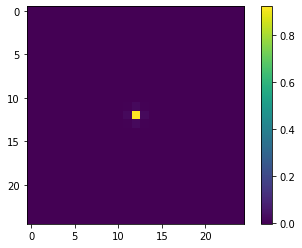

In [18]:
plt.imshow(output_tensor.cpu().detach().numpy()[0][0])
plt.colorbar()

#### one time step - skipping layers

In [26]:
class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c_value, sigma2_inv):
        output_list = [status_tn]

        c_ones = torch.ones((self.xysize, self.xysize), device=device, requires_grad=True)
        c = c_value * c_ones
        

        # Calculate status_tn1 based on the provided expression
        c_status_tn = c * status_tn
        conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
        
        status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        
        output_list.append(status_tn1)

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

#### multi time step - skipping layers

In [20]:
class ConstantCValueLayer(nn.Module):
    def __init__(self, xysize):
        super(ConstantCValueLayer, self).__init__()
        self.xysize = xysize

    def forward(self, c_value):
        c_value.retain_grad()
        c = torch.full((self.xysize, self.xysize), c_value.item(), device=device, requires_grad=True)
        return c

In [21]:
class AI4WaveNeuralNetwork_Multi_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_Multi_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.constant_layer = ConstantCValueLayer(xysize)

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c_value, sigma2_inv, nsteps):
        output_list = [status_tn_1, status_tn]

        # c = self.constant_layer(c_value)
        # c = torch.full((self.xysize, self.xysize), c_value.item(), device=device, requires_grad=True)
        c_ones = torch.ones((self.xysize, self.xysize), device=device, requires_grad=True)
        c = c_value * c_ones

        for i in range(nsteps):
            # Calculate status_tn1 based on the provided expression
            c_status_tn = c * status_tn
            conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
            
            status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
            
            output_list.append(status_tn1)

            status_tn_1 = status_tn
            status_tn = status_tn1

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

### Data assimilation one timestep - skipping layers

#### Generate Obs

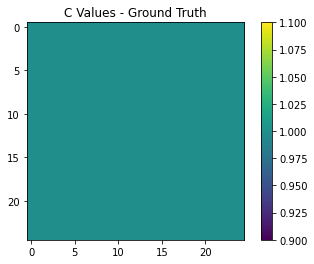

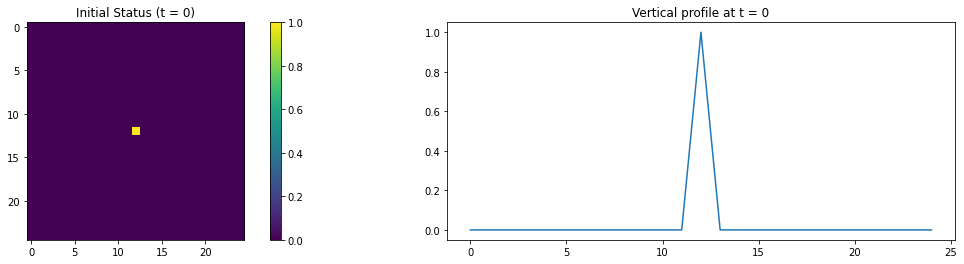

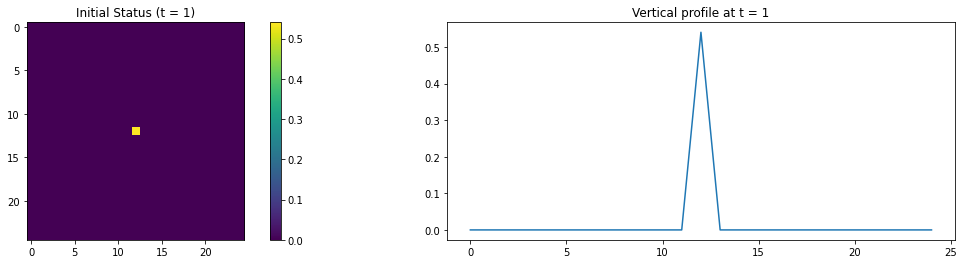

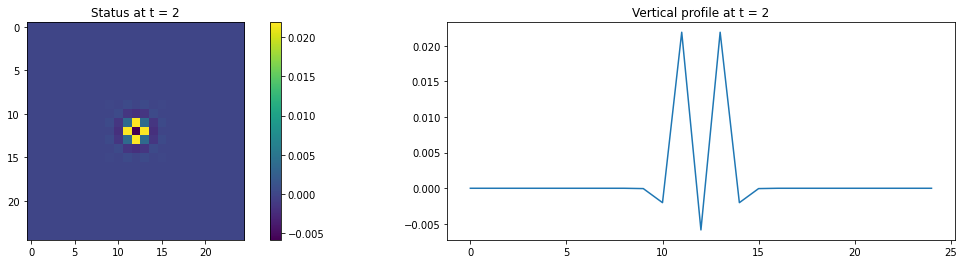

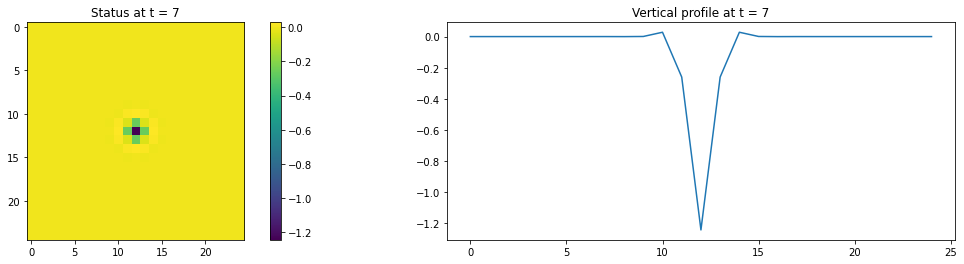

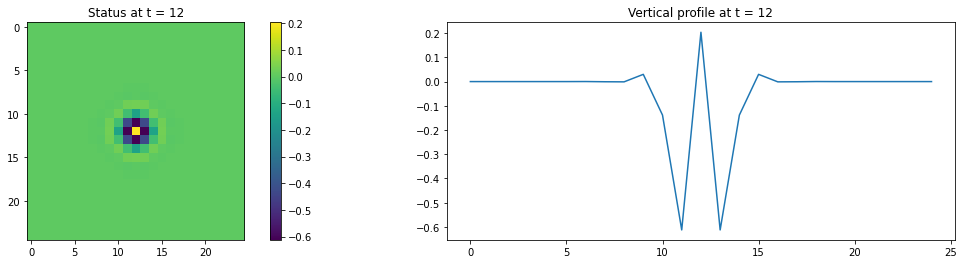

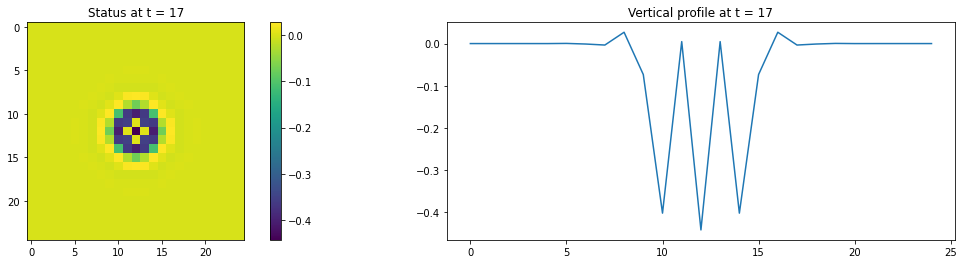

torch.Size([1, 22, 25, 25])


In [22]:
# Specify the size of the tensor
xysize = 25

timesteps = 20

# C values
c_tensor = torch.tensor(2.0, dtype=torch.float32, device=device, requires_grad=True)

# Plot C
plt.imshow(c_np, cmap='viridis')
plt.colorbar()
plt.title('C Values - Ground Truth')
plt.show()

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Assume xysize, filter, and status_t0 are already defined
xysize = 25  # Replace with your actual value
filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

mymodel_multi = AI4WaveNeuralNetwork_Multi_Skipping(xysize, filter_weight)

status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

# Perform a forward pass using AI4WaveNeuralNetwork
status_t1_tensor = status_t1.view(1, 1, xysize, xysize).to(device)

# Initial Status (t = 0)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t0.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 0)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t0.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 0")

plt.show()

# Initial Status (t = 1)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t1.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 1)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t1.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 1")

plt.show()

output_tensor_obs = mymodel_multi(status_t1_tensor, status_t0_tensor, c_tensor, sigma2, nsteps = timesteps)

for i in range(timesteps):
    if (i) % 5 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

        # Plot the image on the first subplot
        im = axs[0].imshow(output_tensor_obs.cpu().detach().numpy()[0][i+2], cmap='viridis')
        fig.colorbar(im, ax=axs[0])
        axs[0].set_title(f"Status at t = {i+2}")

        # Plot the vertical profile on the second subplot
        vertical_profile = output_tensor_obs.cpu().detach().numpy()[0][i+2][xysize//2, :]  # Take the middle row
        axs[1].plot(vertical_profile)
        axs[1].set_title(f"Vertical profile at t = {i+2}")

        plt.show()

print(output_tensor_obs.shape)

In [23]:
Status_List_stacked_obs = output_tensor_obs.squeeze(0)
print(Status_List_stacked_obs.shape)

torch.Size([22, 25, 25])


#### One time forward stepping

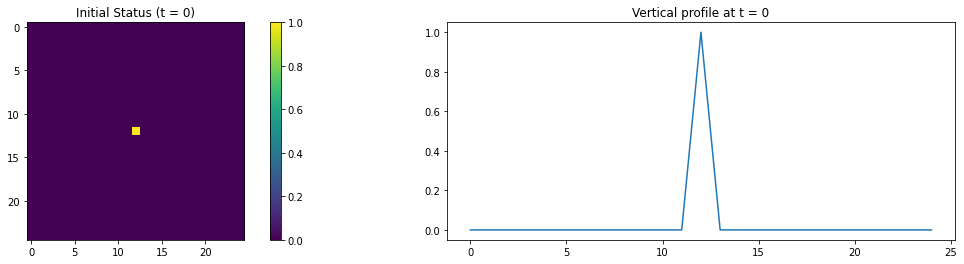

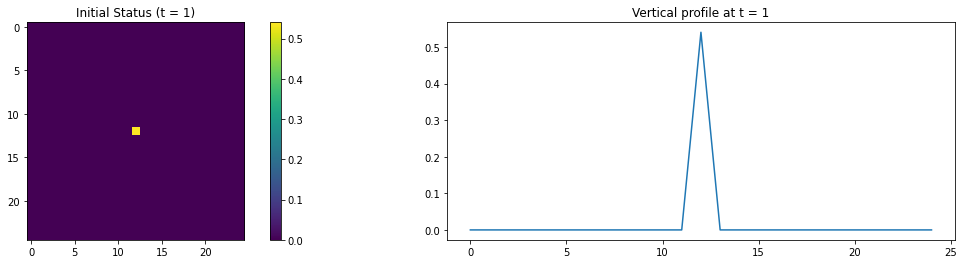

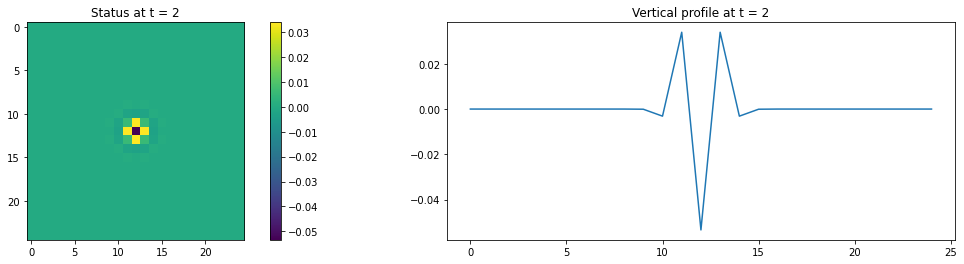

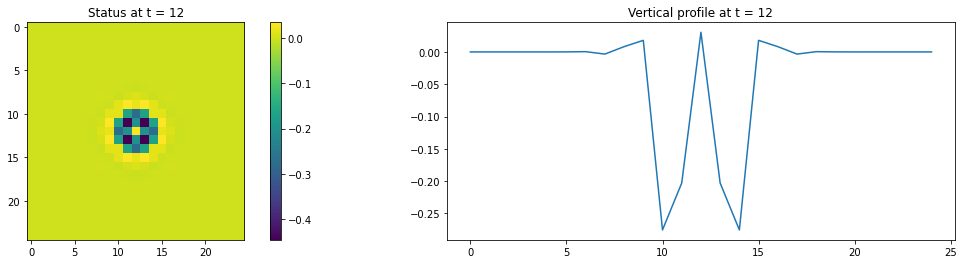

In [27]:
# C guess
c_forward1 = torch.tensor(3.1, dtype=torch.float32, device=device, requires_grad=True)

c_values = [c_forward1.item()]

mymodel_onestepSkip = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

Status_List_onestep = []
Status_List_onestep.append(status_t0.view(1, 1, xysize, xysize).to(device))
Status_List_onestep.append(status_t1.view(1, 1, xysize, xysize).to(device))
status_t0 = status_t0.to(device)
status_t1 = status_t1.to(device)

# vmin, vmax = -1, 1  # Set vmin and vmax

# Initial Status (t = 0)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t0.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 0)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t0.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 0")

plt.show()

# Initial Status (t = 1)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t1.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 1)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t1.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 1")

plt.show()

status_tn_1 = status_t0.view(1, 1, xysize, xysize)
status_tn = status_t1.view(1, 1, xysize, xysize)

for i in range(timesteps):
    status_tn_1 = status_tn_1.to(device)
    status_tn = status_tn.to(device)

    # Perform a forward pass
    output = mymodel_onestepSkip(status_tn, status_tn_1, c_forward1, sigma2)
    status_tn1 = output[:, 1, :, :].view(1, 1, xysize, xysize)
    
    # plt.figure(figsize=(10, 4))
    # plt.imshow(status_tn1.cpu().detach().numpy()[0][0], vmin=vmin, vmax=vmax, cmap='viridis')
    # # plt.imshow(status_tn1.cpu().detach().numpy()[0][0], cmap='viridis')
    # plt.colorbar()
    # plt.title(f"Status at t = {i+1}")
    status_detached = status_tn1.cpu().detach().numpy()[0][0]
    Status_List_onestep.append(status_tn1)

    status_tn_1 = status_tn
    status_tn = status_tn1

    # Plot the result for every 100 timesteps
    # Plot the result for every 100 timesteps
    if (i) % 10 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

        # Plot the image on the first subplot
        im = axs[0].imshow(status_tn1.cpu().detach().numpy()[0][0], cmap='viridis')
        fig.colorbar(im, ax=axs[0])
        axs[0].set_title(f"Status at t = {i+2}")

        # Plot the vertical profile on the second subplot
        vertical_profile = status_tn1.cpu().detach().numpy()[0][0][xysize//2, :]  # Take the middle row
        axs[1].plot(vertical_profile)
        axs[1].set_title(f"Vertical profile at t = {i+2}")

        plt.show()
    
    # return Status_List_onestep


# Status_List_onestep = plot_diffusion(status_t0, status_t1, 200)

In [28]:
Status_List_onestep_stacked = torch.cat(Status_List_onestep, dim=1)
print(Status_List_onestep_stacked.shape)

torch.Size([1, 22, 25, 25])


#### Place sensors

In [29]:
status_t0_np = status_t0.cpu().numpy() if isinstance(status_t0, torch.Tensor) else status_t0

# Set a seed for reproducibility
np.random.seed(42)

# Create an array of all indices
all_indices = np.arange(status_t0_np.size)

# Number of points to randomly select
num_points_to_select = 10

x_indices = np.linspace(0, xysize - 1, num_points_to_select, dtype=int)
y_indices = np.linspace(0, xysize - 1, num_points_to_select, dtype=int)

# x_selected, y_selected = np.meshgrid(x_indices, y_indices, indexing='ij')

# Combine x and y indices into a tuple
selected_indices = (x_indices, y_indices)

# Print the selected indices
print("Selected Indices:")
print(selected_indices)

Selected Indices:
(array([ 0,  2,  5,  8, 10, 13, 16, 18, 21, 24]), array([ 0,  2,  5,  8, 10, 13, 16, 18, 21, 24]))


In [30]:
print(selected_indices[0].shape)

(10,)


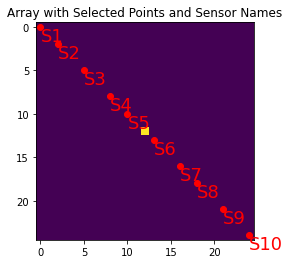

In [31]:
sensor_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

# Visualize the array and selected points
plt.imshow(status_t0.cpu(), interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[0], selected_indices[1], color='red', marker='o')

# Annotate each point with the corresponding sensor name
for i, name in enumerate(sensor_names):
    plt.text(selected_indices[0][i], selected_indices[1][i], name, color='red', fontsize=18, ha='left', va='top')

plt.title('Array with Selected Points and Sensor Names')
plt.show()

In [32]:
Status_List_stacked_onestep = Status_List_onestep_stacked.squeeze(0)
print(Status_List_stacked_onestep.shape)

torch.Size([22, 25, 25])


In [34]:
Status_List_stacked_obs = output_tensor_obs.squeeze(0)
print(Status_List_stacked_obs.shape)

torch.Size([22, 25, 25])


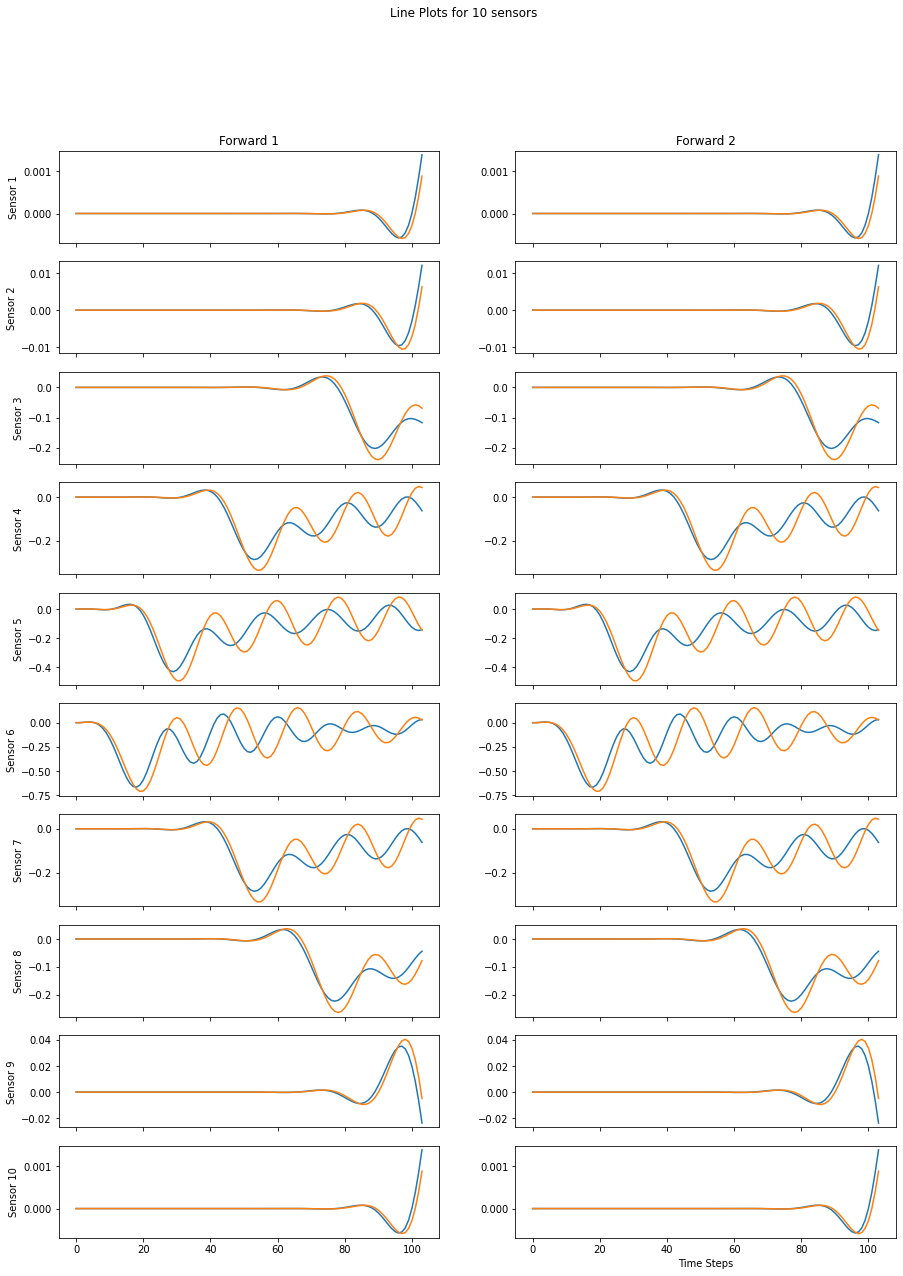

-0.4593883977504447
-0.4593883977504447


In [37]:
# Get the values at the selected sensors
selected_sensor_values1 = Status_List_stacked_onestep[:, selected_indices[0], selected_indices[1]]
selected_sensor_values2 = Status_List_stacked_forward2[:, selected_indices[0], selected_indices[1]]
selected_sensor_values_obs = Status_List_stacked_obs[:, selected_indices[0], selected_indices[1]]

# Create a 2D grid of subplots
fig, axs = plt.subplots(num_points_to_select, 2, figsize=(15, 20), sharex=True)

loss_f1 = []
loss_f2 = []

for i in range(num_points_to_select):
    # Plot the data for forward 1 in the first column
    axs[i, 0].plot(selected_sensor_values1.cpu().detach().numpy()[:, i])
    axs[i, 0].plot(selected_sensor_values_obs.cpu().detach().numpy()[:, i])
    axs[i, 0].set_ylabel(f'Sensor {i + 1}')
    loss_f1.append(np.sum((selected_sensor_values1.cpu().detach().numpy()[:, i] - selected_sensor_values_obs.cpu().detach().numpy()[:, i])))
    if i == 0:
        axs[i, 0].set_title('Forward 1')

    # Plot the data for forward 2 in the second column
    axs[i, 1].plot(selected_sensor_values2.cpu().detach().numpy()[:, i])
    axs[i, 1].plot(selected_sensor_values_obs.cpu().detach().numpy()[:, i])
    loss_f2.append(np.sum((selected_sensor_values2.cpu().detach().numpy()[:, i] - selected_sensor_values_obs.cpu().detach().numpy()[:, i])))
    if i == 0:
        axs[i, 1].set_title('Forward 2')

plt.xlabel('Time Steps')
plt.suptitle('Line Plots for 10 sensors')
plt.show()

print(sum(loss_f1))
print(sum(loss_f2))

#### Create data mismatch between two forward simulations

In [35]:
observational_3d_array_onestep = torch.zeros(Status_List_stacked_onestep.size())

# Extract indices from the selected_indices tuple
x_indices, y_indices = selected_indices

# Iterate through the sensors and update the values in the original array
for sensor_index in range(len(x_indices)):
    x_index = x_indices[sensor_index]
    y_index = y_indices[sensor_index]

    # Update the values with the synthetic_observational_data
    observational_3d_array_onestep[:, x_index, y_index] =  Status_List_stacked_onestep[:, x_index, y_index]

print(observational_3d_array_onestep.shape)
print(sum(sum(sum(observational_3d_array_onestep))))

torch.Size([22, 25, 25])
tensor(-4.4772, grad_fn=<AddBackward0>)


#### Backpropogate one step

In [39]:
# Initialize the model
mymodel = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)


# Define the number of steps
num_steps = timesteps

# Initialize c_np
c_np = np.ones((xysize, xysize)) * 1

# Calculate the center indices
center_x, center_y = xysize // 2, xysize // 2

# Set the center grid value to 4
c_np[center_x, center_y] = 2

# Convert c_np to a tensor
c = torch.from_numpy(c_np).float().requires_grad_().to(device)

# Initialize a list to store the gradients
grad_values = []

# Loop over the number of steps
for i in range(0, num_steps):
    # Get the status at time n and n-1
    status_tn = Status_List_onestep[-(i+2)].clone()
    status_tn_1 = Status_List_onestep[-(i+3)].clone()

    # Forward pass
    output_3ts = mymodel(status_tn, status_tn_1, c, sigma2).squeeze(0)

    # Compute the loss
    # print(-(i+3), -i)
    # print(observational_3d_array_onestep[-3:].shape)
    if i == 0:
        dF = 2*(output_3ts - observational_3d_array_onestep[-2:].to(device))
    if i > 0:
        dF = 2*(output_3ts - observational_3d_array_onestep[-(i+2):-i].to(device))
    loss = dF + c.grad if i > 0 else dF

    # Backward pass
    output_3ts.backward(loss, retain_graph=True)

    # Add the gradient value to the list
    grad_values.append(c.grad)

# Plot the gradient values
plt.plot(grad_values)
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.show()

TypeError: unsupported operand type(s) for +: 'Tensor' and 'NoneType'

In [41]:
def multi_backpropagate(num_steps, observational_3d_array_onestep, c, sigma2):
    # Initialize a list to store the gradient values
    grad_values = []

    # Loop over the number of steps
    for i in range(0, num_steps):
        # Get the status at time n and n-1
        status_tn = Status_List_onestep[-(i+2)].clone()
        status_tn_1 = Status_List_onestep[-(i+3)].clone()

        # Forward pass
        output_3ts = mymodel(status_tn, status_tn_1, c, sigma2).squeeze(0)

        # Compute the loss
        if i == 0:
            dF = 2*(output_3ts - observational_3d_array_onestep[-3:].to(device))
        if i > 0:
            dF = 2*(output_3ts - observational_3d_array_onestep[-(i+3):-i].to(device))
        loss = dF + c.grad if i > 0 else dF

        # Backward pass
        output_3ts.backward(loss, retain_graph=True)

        # Add the gradient value to the list
        grad_values.append(c.grad.data.norm().item())

    # Plot the gradient values
    plt.plot(grad_values)
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.show()

    return grad_values

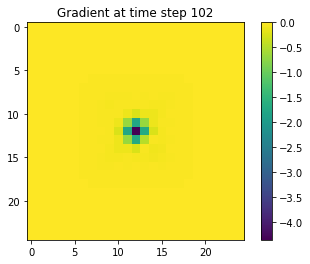

In [42]:
import matplotlib.pyplot as plt

# Define the number of steps
num_steps = 102

# Initialize the loss function
mse_loss = nn.MSELoss()

# Initialize the model
mymodel = AI4WaveNeuralNetwork(xysize, filter_weight)

# Initialize c_np
c_np = np.ones((xysize, xysize)) * 1

# Calculate the center indices
center_x, center_y = xysize // 2, xysize // 2

# Set the center grid value to 4
c_np[center_x, center_y] = 2

# Convert c_np to a tensor
c = torch.from_numpy(c_np).float().requires_grad_().to(device)

# Loop over the number of steps
for i in range(num_steps):
    # Get the status at time n and n-1
    status_tn = Status_List_onestep[-(i+2)].clone()
    status_tn_1 = Status_List_onestep[-(i+3)].clone()

    # Forward pass
    status_tn1 = mymodel(status_tn, status_tn_1, c, sigma2).squeeze(0)

    # Compute the loss
    dF = 2*(status_tn1 - observational_3d_array_onestep[-(i+1)].to(device))
    loss = dF + c.grad if i > 0 else dF

    # Backward pass
    status_tn1.backward(loss, retain_graph=True)

# Plot the gradient
plt.figure()
plt.imshow(c.grad.cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title(f'Gradient at time step {i+1}')
plt.show()

In [43]:
print(sum(sum(c_onestep.grad)))

tensor(-1318.4362, device='cuda:0')


In [44]:
print(torch.sum(torch.abs(c_onestep.grad)))

tensor(1323.7432, device='cuda:0')


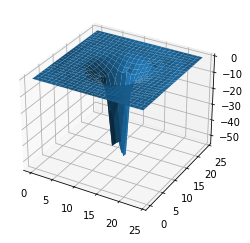

In [45]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming c_onestep.grad is a 2D Tensor
grad_np = c_onestep.grad.cpu().numpy()

x = np.arange(grad_np.shape[1])
y = np.arange(grad_np.shape[0])
x, y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, grad_np)

plt.show()

In [46]:
# Initialize c_onestep_new outside the loop
c_np_onestep_new = np.ones((xysize, xysize)) * 1
center_x, center_y = xysize // 2, xysize // 2
c_np_onestep_new[center_x, center_y] = 2
c_onestep_new = torch.from_numpy(c_np_onestep_new).float().requires_grad_().to(device)

status_tn = Status_List_onestep[-2].clone()
status_tn_1 = Status_List_onestep[-3].clone()

# Reinitialize the model
mymodel_onestep_new = AI4WaveNeuralNetwork(xysize, filter_weight)

# Compute a numerical approximation of the gradient
c_onestep_new_numerical_grad = c_onestep_new.clone()
# epsilon = 1e-1
epsilon = 1

for i in range(c_onestep_new.size(0)):
    for j in range(c_onestep_new.size(1)):
        
        c_onestep_new_plus = c_onestep_new.clone()
        c_onestep_new_plus[i, j] += epsilon
        status_tn1_plus = mymodel_onestep_new(status_tn, status_tn_1, c_onestep_new_plus, sigma2).squeeze(0)
        loss_plus = mse_loss(status_tn1_plus, observational_3d_array_onestep[-1].to(device))

        
        c_onestep_new_minus = c_onestep_new.clone()
        c_onestep_new_minus[i, j] -= epsilon
        status_tn1_minus = mymodel_onestep_new(status_tn, status_tn_1, c_onestep_new_minus, sigma2).squeeze(0)
        loss_minus = mse_loss(status_tn1_minus, observational_3d_array_onestep[-1].to(device))
        
        c_onestep_new_numerical_grad[i, j] = (loss_plus - loss_minus) / (2 * epsilon)

print(c_onestep_new_numerical_grad)

/home/dg321/anaconda3/envs/icdss/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([25, 25])) that is different to the input size (torch.Size([1, 25, 25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[ 0.0000e+00, -1.8626e-09,  5.1223e-09, -7.4506e-09, -1.2107e-08,
          7.5903e-08,  1.3039e-07,  3.8184e-08, -7.3574e-08, -1.0431e-07,
         -1.0710e-07, -1.1502e-07, -1.2014e-07, -1.1502e-07, -1.0710e-07,
         -1.0431e-07, -7.3574e-08,  3.8184e-08,  1.3039e-07,  7.6368e-08,
         -1.2107e-08, -7.4506e-09,  6.0536e-09, -1.8626e-09,  0.0000e+00],
        [-2.3283e-09,  9.3132e-09, -2.3283e-08, -1.8626e-08,  7.8697e-08,
         -3.9674e-07, -8.5775e-07, -6.2957e-07, -2.0117e-07,  2.1420e-08,
          1.0012e-07,  1.2526e-07,  1.3085e-07,  1.2573e-07,  1.0012e-07,
          2.1420e-08, -2.0163e-07, -6.2864e-07, -8.5728e-07, -3.9721e-07,
          7.8697e-08, -1.8626e-08, -2.9337e-08,  7.4506e-09, -1.8626e-09],
        [ 5.1223e-09, -2.3283e-08, -3.6322e-08, -4.0978e-08, -8.4611e-07,
         -1.0300e-06, -7.5810e-07, -4.2561e-07, -6.0536e-08,  1.0291e-07,
          9.7323e-08,  6.2864e-08,  4.8429e-08,  6.2864e-08,  9.7323e-08,
          1.0291e-07, -6.1002e-08, -

In [47]:
print(sum(sum(c_onestep_new_numerical_grad)))

tensor(-0.0004, device='cuda:0', grad_fn=<AddBackward0>)


In [48]:
# Compute the relative error
relative_error = (c_onestep.grad - c_onestep_new_numerical_grad).norm() / (c_onestep.grad.norm() + c_onestep_new_numerical_grad.norm())

print('Relative Error: ', relative_error.item())

Relative Error:  0.9999988079071045


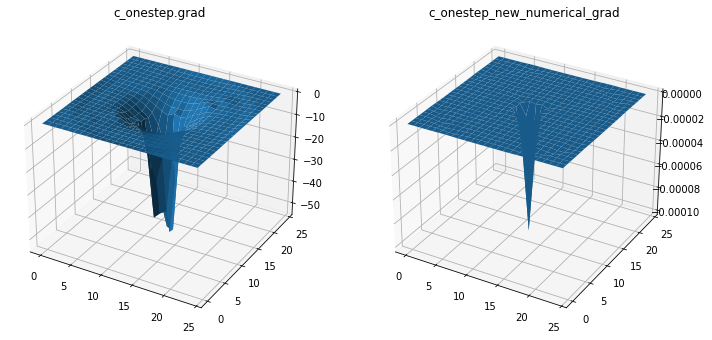

In [49]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming c_onestep.grad and c_onestep_new_numerical_grad are 2D Tensors
grad_np = c_onestep.grad.cpu().numpy()
new_grad_np = c_onestep_new_numerical_grad.cpu().detach().numpy()

x = np.arange(grad_np.shape[1])
y = np.arange(grad_np.shape[0])
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 6))

# Plot c_onestep.grad
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, grad_np)
ax1.set_title('c_onestep.grad')

# Plot c_onestep_new_numerical_grad
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, new_grad_np)
ax2.set_title('c_onestep_new_numerical_grad')

plt.show()

### Data assimilation Validation

#### Generate Obs

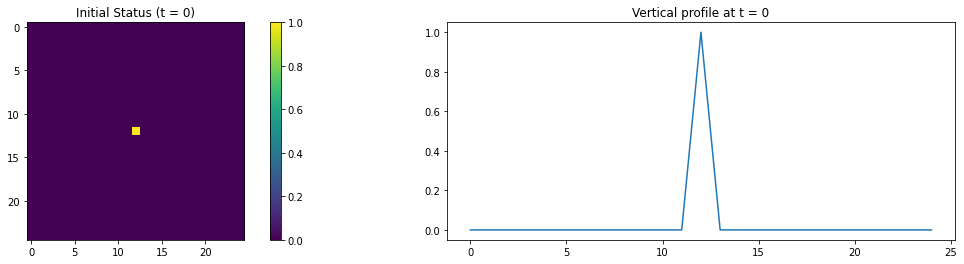

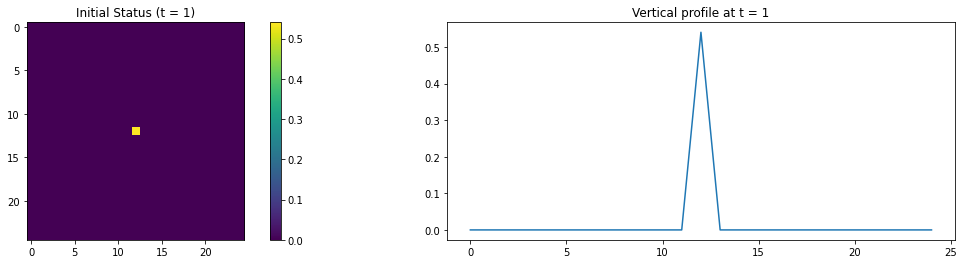

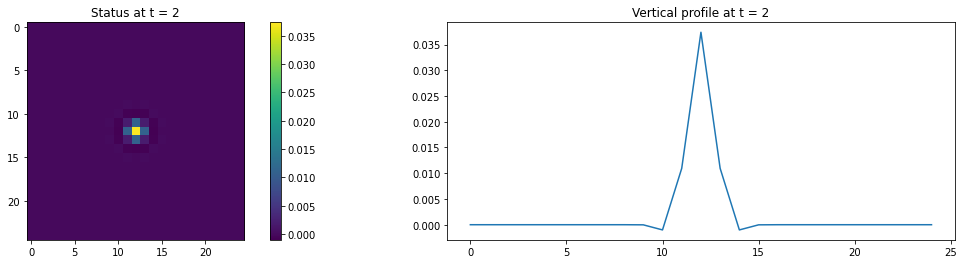

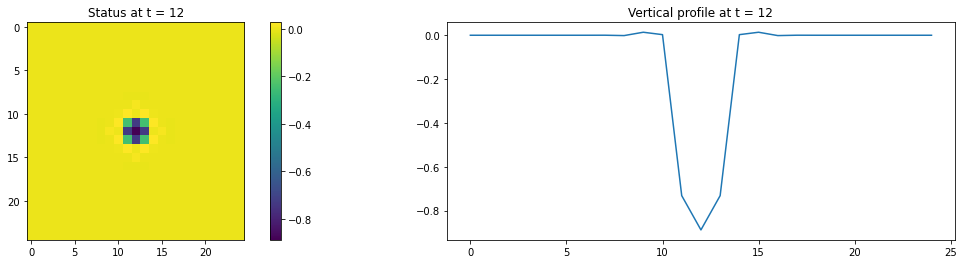

torch.Size([1, 22, 25, 25])


In [74]:
# Specify the size of the tensor
xysize = 25

timesteps = 20

# C values
c_np = np.ones((xysize, xysize))
# uncomment to make the values different
# right_half_start = xysize // 2
# c_np[:, right_half_start:] = 2
c = torch.from_numpy(c_np).float().requires_grad_()
c_tensor = c.to(device)

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Assume xysize, filter, and status_t0 are already defined
xysize = 25  # Replace with your actual value
filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

mymodel_multi = AI4WaveNeuralNetwork_Multi_Skipping(xysize, filter_weight)

status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

# Perform a forward pass using AI4WaveNeuralNetwork
status_t1_tensor = status_t1.view(1, 1, xysize, xysize).to(device)

# Initial Status (t = 0)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t0.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 0)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t0.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 0")

plt.show()

# Initial Status (t = 1)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t1.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 1)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t1.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 1")

plt.show()

output_tensor_obs = mymodel_multi(status_t1_tensor, status_t0_tensor, c_tensor, sigma2, nsteps = timesteps)

for i in range(timesteps):
    if (i) % 10 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

        # Plot the image on the first subplot
        im = axs[0].imshow(output_tensor_obs.cpu().detach().numpy()[0][i+2], cmap='viridis')
        fig.colorbar(im, ax=axs[0])
        axs[0].set_title(f"Status at t = {i+2}")

        # Plot the vertical profile on the second subplot
        vertical_profile = output_tensor_obs.cpu().detach().numpy()[0][i+2][xysize//2, :]  # Take the middle row
        axs[1].plot(vertical_profile)
        axs[1].set_title(f"Vertical profile at t = {i+2}")

        plt.show()

print(output_tensor_obs.shape)

#### Forward 1

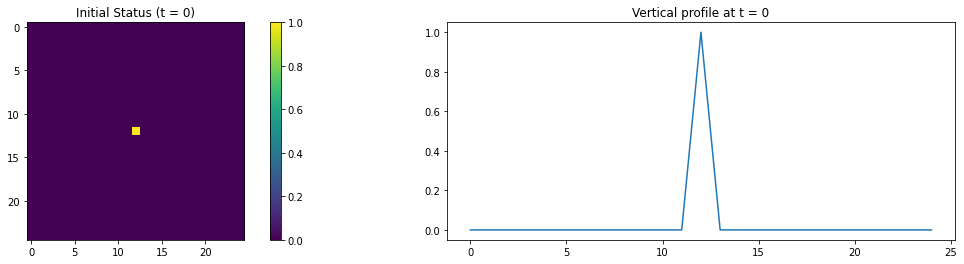

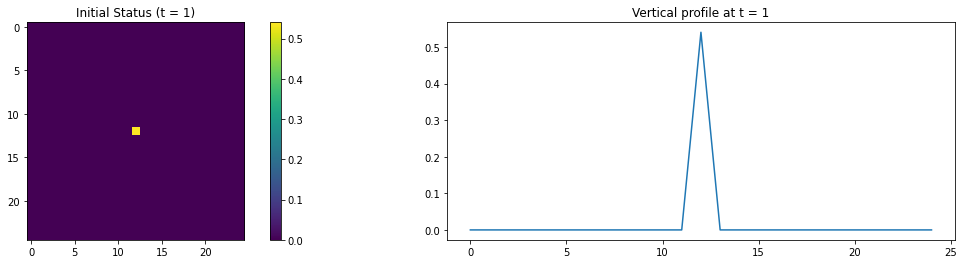

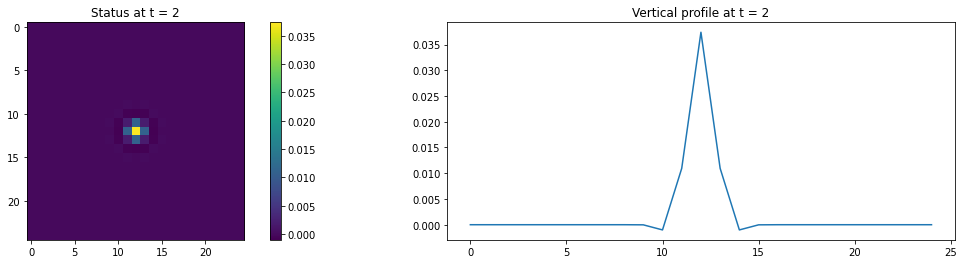

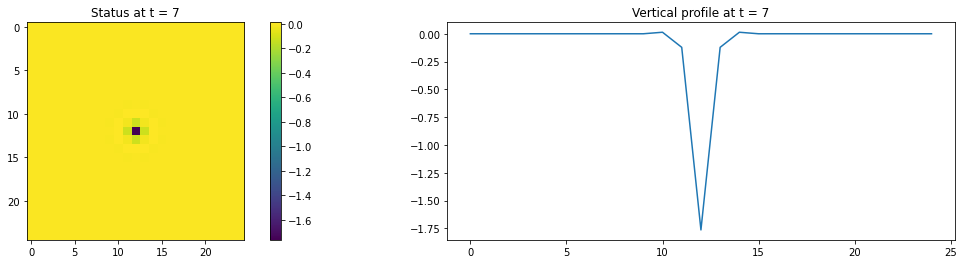

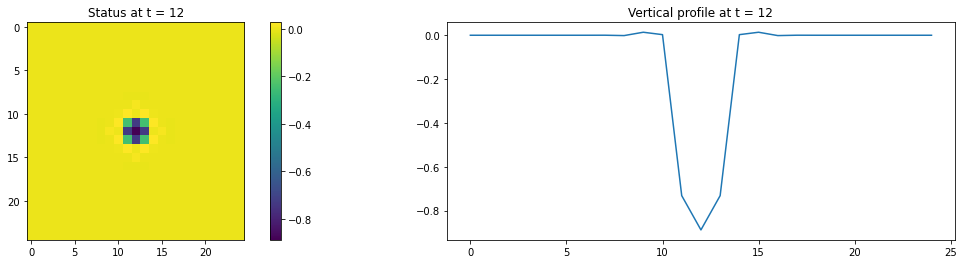

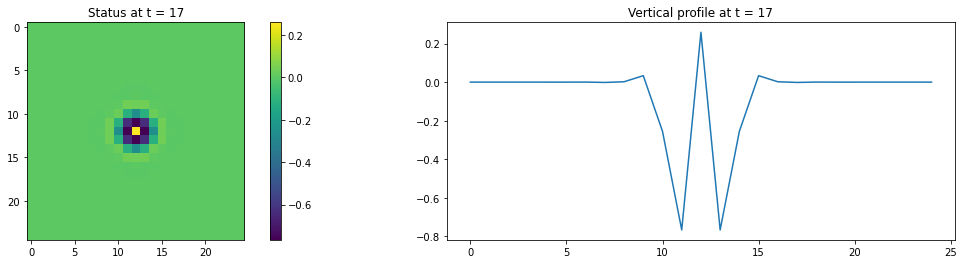

torch.Size([1, 22, 25, 25])


In [75]:
# Specify the size of the tensor
xysize = 25

c_np_forward1 = np.ones((xysize, xysize)) * 1
# uncomment to make the values different
# right_half_start = xysize // 2
# c_np_forward1[:, right_half_start:] = 2

# Calculate the center indices
center_x, center_y = xysize // 2, xysize // 2
# Set the center grid value to 4
c_np_forward1[center_x + 5, center_y + 5] = 1.5

c_forward1 = torch.from_numpy(c_np_forward1).float().requires_grad_().to(device)

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Assume xysize, filter, and status_t0 are already defined
xysize = 25  # Replace with your actual value
filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

mymodel_multi_forward1 = AI4WaveNeuralNetwork_Multi_Skipping(xysize, filter_weight)

status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

# Perform a forward pass using AI4WaveNeuralNetwork
status_t1_tensor = status_t1.view(1, 1, xysize, xysize).to(device)

# Initial Status (t = 0)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t0.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 0)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t0.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 0")

plt.show()

# Initial Status (t = 1)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t1.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 1)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t1.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 1")

plt.show()

output_tensor_forward1 = mymodel_multi(status_t1_tensor, status_t0_tensor, c_forward1, sigma2, nsteps = timesteps)

for i in range(timesteps):
    if (i) % 5 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

        # Plot the image on the first subplot
        im = axs[0].imshow(output_tensor_forward1.cpu().detach().numpy()[0][i+2], cmap='viridis')
        fig.colorbar(im, ax=axs[0])
        axs[0].set_title(f"Status at t = {i+2}")

        # Plot the vertical profile on the second subplot
        vertical_profile = output_tensor_forward1.cpu().detach().numpy()[0][i+2][xysize//2, :]  # Take the middle row
        axs[1].plot(vertical_profile)
        axs[1].set_title(f"Vertical profile at t = {i+2}")

        plt.show()

print(output_tensor_forward1.shape)

#### Forward 2

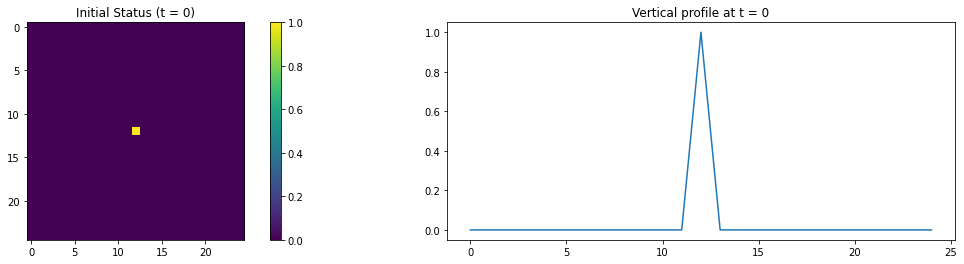

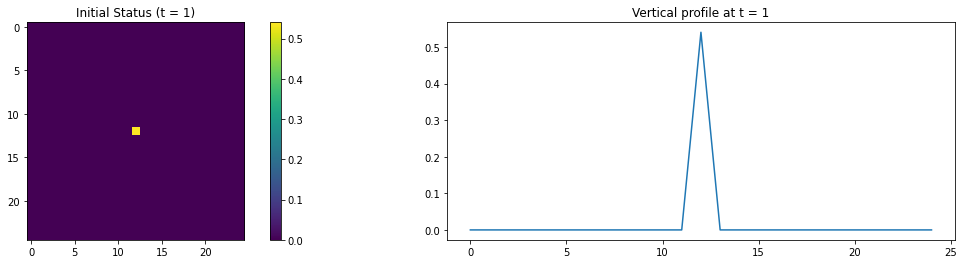

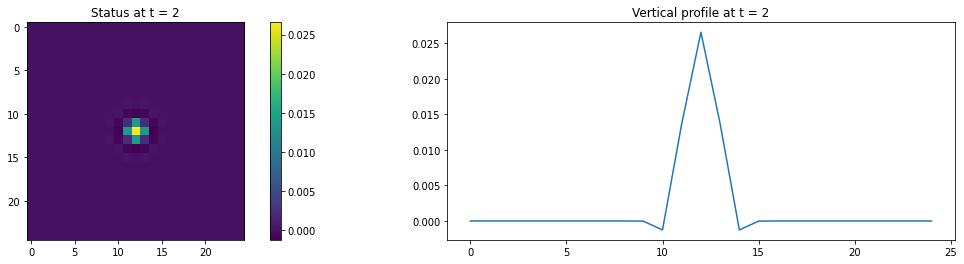

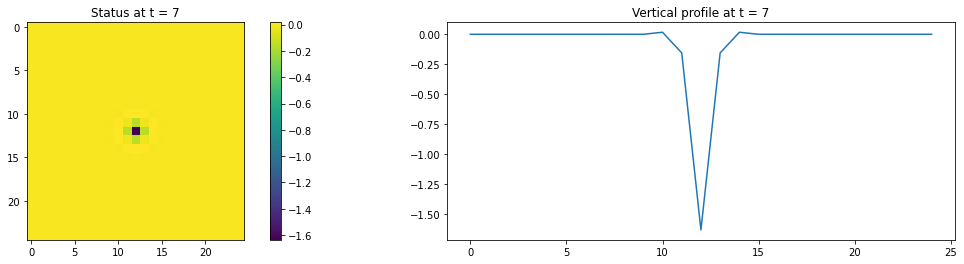

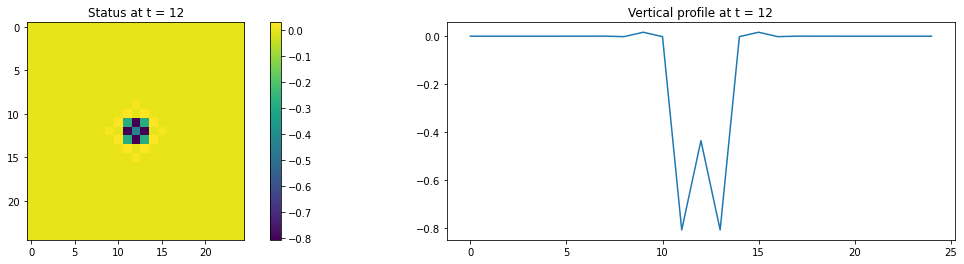

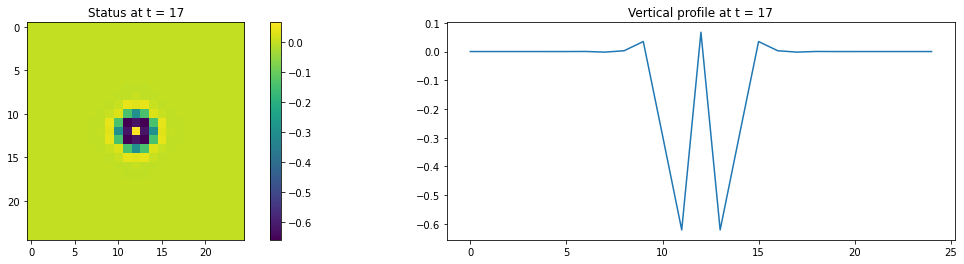

torch.Size([1, 22, 25, 25])


In [76]:
# Specify the size of the tensor
xysize = 25

c_np_forward2 = np.ones((xysize, xysize)) * 1

# uncomment to make the values different
# right_half_start = xysize // 2
# c_np_forward2[:, right_half_start:] = 2

# Calculate the center indices
center_x, center_y = xysize // 2, xysize // 2
# Set the center grid value to 4
c_np_forward2[center_x, center_y] = 1.5

c_forward2 = torch.from_numpy(c_np_forward2).float().requires_grad_().to(device)

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Assume xysize, filter, and status_t0 are already defined
xysize = 25  # Replace with your actual value
filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

mymodel_multi_forward2 = AI4WaveNeuralNetwork_Multi_Skipping(xysize, filter_weight)

status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

# Perform a forward pass using AI4WaveNeuralNetwork
status_t1_tensor = status_t1.view(1, 1, xysize, xysize).to(device)

# Initial Status (t = 0)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t0.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 0)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t0.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 0")

plt.show()

# Initial Status (t = 1)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t1.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 1)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t1.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 1")

plt.show()

output_tensor_forward2 = mymodel_multi_forward2(status_t1_tensor, status_t0_tensor, c_forward2, sigma2, nsteps = timesteps)

for i in range(timesteps):
    if (i) % 5 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

        # Plot the image on the first subplot
        im = axs[0].imshow(output_tensor_forward2.cpu().detach().numpy()[0][i+2], cmap='viridis')
        fig.colorbar(im, ax=axs[0])
        axs[0].set_title(f"Status at t = {i+2}")

        # Plot the vertical profile on the second subplot
        vertical_profile = output_tensor_forward2.cpu().detach().numpy()[0][i+2][xysize//2, :]  # Take the middle row
        axs[1].plot(vertical_profile)
        axs[1].set_title(f"Vertical profile at t = {i+2}")

        plt.show()

print(output_tensor_forward2.shape)

#### Place sensors

In [77]:
status_t0_np = status_t0.cpu().numpy() if isinstance(status_t0, torch.Tensor) else status_t0

# Set a seed for reproducibility
np.random.seed(42)

# Create an array of all indices
all_indices = np.arange(status_t0_np.size)

# Number of points to randomly select
num_points_to_select = 10

x_indices = np.linspace(0, xysize-1, num_points_to_select, dtype=int)
y_indices = np.linspace(0, xysize-1, num_points_to_select, dtype=int)

# x_selected, y_selected = np.meshgrid(x_indices, y_indices, indexing='ij')

# Combine x and y indices into a tuple
selected_indices = (x_indices, y_indices)

# Print the selected indices
print("Selected Indices:")
print(selected_indices)

Selected Indices:
(array([ 0,  2,  5,  8, 10, 13, 16, 18, 21, 24]), array([ 0,  2,  5,  8, 10, 13, 16, 18, 21, 24]))


In [78]:
print(selected_indices[0].shape)

(10,)


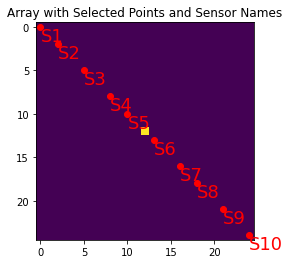

In [79]:
sensor_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

# Visualize the array and selected points
plt.imshow(status_t0.cpu(), interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[0], selected_indices[1], color='red', marker='o')

# Annotate each point with the corresponding sensor name
for i, name in enumerate(sensor_names):
    plt.text(selected_indices[0][i], selected_indices[1][i], name, color='red', fontsize=18, ha='left', va='top')

plt.title('Array with Selected Points and Sensor Names')
plt.show()

In [80]:
Status_List_stacked_forward1 = output_tensor_forward1.squeeze(0)
print(Status_List_stacked_forward1.shape)

torch.Size([22, 25, 25])


In [81]:
Status_List_stacked_forward2 = output_tensor_forward2.squeeze(0)
print(Status_List_stacked_forward2.shape)

torch.Size([22, 25, 25])


In [82]:
Status_List_stacked_obs = output_tensor_obs.squeeze(0)
print(Status_List_stacked_obs.shape)

torch.Size([22, 25, 25])


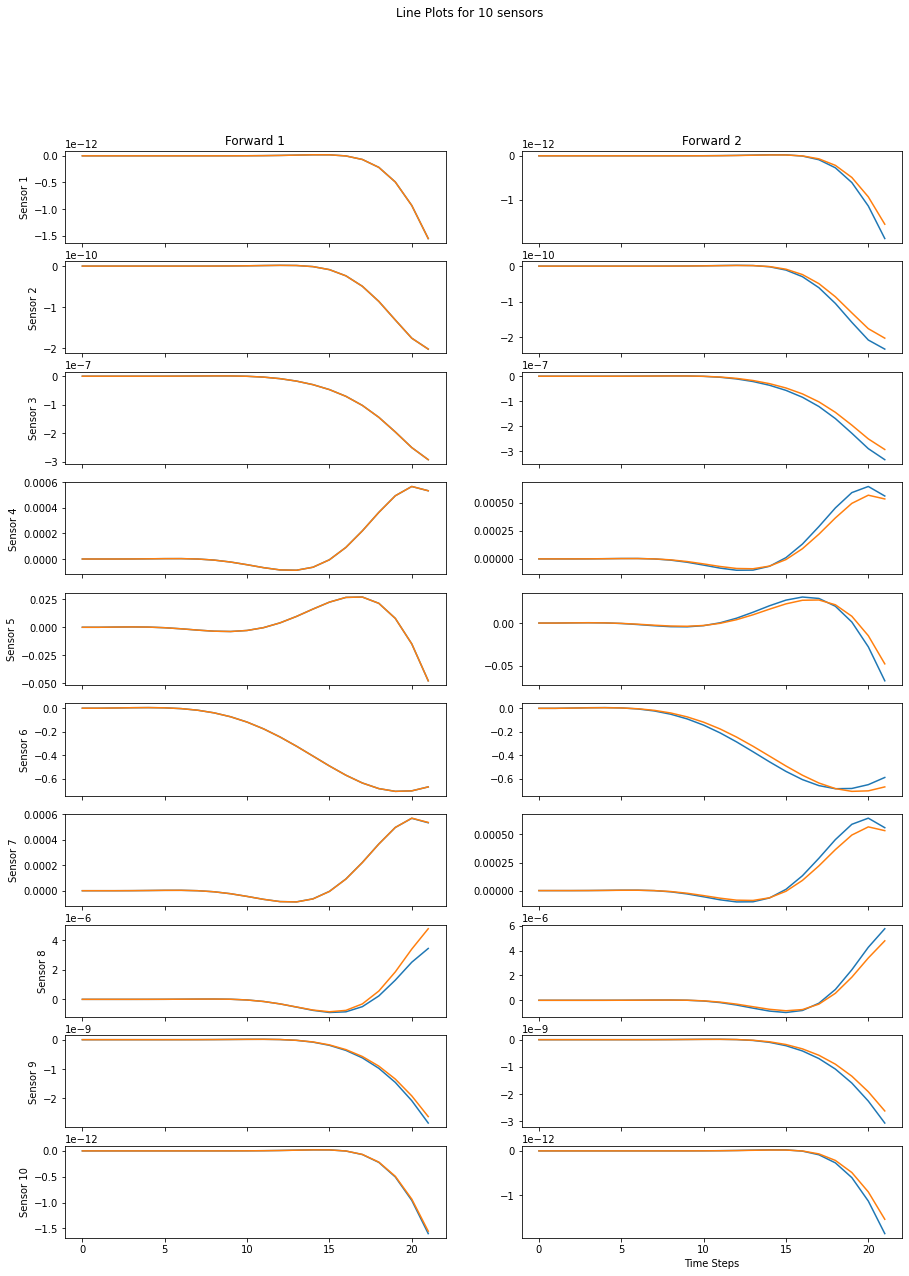

-2.5812282274323493e-06
-0.19986980571702176


In [83]:
import matplotlib.pyplot as plt

# Get the values at the selected sensors
selected_sensor_values1 = Status_List_stacked_forward1[:, selected_indices[0], selected_indices[1]]
selected_sensor_values2 = Status_List_stacked_forward2[:, selected_indices[0], selected_indices[1]]
selected_sensor_values_obs = Status_List_stacked_obs[:, selected_indices[0], selected_indices[1]]

# Create a 2D grid of subplots
fig, axs = plt.subplots(num_points_to_select, 2, figsize=(15, 20), sharex=True)

loss_f1 = []
loss_f2 = []

for i in range(num_points_to_select):
    # Plot the data for forward 1 in the first column
    axs[i, 0].plot(selected_sensor_values1.cpu().detach().numpy()[:, i])
    axs[i, 0].plot(selected_sensor_values_obs.cpu().detach().numpy()[:, i])
    axs[i, 0].set_ylabel(f'Sensor {i + 1}')
    loss_f1.append(np.sum((selected_sensor_values1.cpu().detach().numpy()[:, i] - selected_sensor_values_obs.cpu().detach().numpy()[:, i])))
    if i == 0:
        axs[i, 0].set_title('Forward 1')

    # Plot the data for forward 2 in the second column
    axs[i, 1].plot(selected_sensor_values2.cpu().detach().numpy()[:, i])
    axs[i, 1].plot(selected_sensor_values_obs.cpu().detach().numpy()[:, i])
    loss_f2.append(np.sum((selected_sensor_values2.cpu().detach().numpy()[:, i] - selected_sensor_values_obs.cpu().detach().numpy()[:, i])))
    if i == 0:
        axs[i, 1].set_title('Forward 2')

plt.xlabel('Time Steps')
plt.suptitle('Line Plots for 10 sensors')
plt.show()

print(sum(loss_f1))
print(sum(loss_f2))

In [84]:
(0.00021857544186323078 - 0.00010417788138243703)/0.001

0.11439756048079375

#### Create data mismatch between two forward simulations

In [87]:
mse_loss = nn.MSELoss()

In [88]:
observational_3d_array_forward1 = torch.zeros(Status_List_stacked_forward1.size())

# Extract indices from the selected_indices tuple
x_indices, y_indices = selected_indices

# Iterate through the sensors and update the values in the original array
for sensor_index in range(len(x_indices)):
    x_index = x_indices[sensor_index]
    y_index = y_indices[sensor_index]

    # Update the values with the synthetic_observational_data
    # observational_3d_array_forward1[:, x_index, y_index] = (Status_List_stacked_obs[:, x_index, y_index] - Status_List_stacked_forward1[:, x_index, y_index]) * 2
    observational_3d_array_forward1[:, x_index, y_index] = mse_loss(Status_List_stacked_obs[:, x_index, y_index], Status_List_stacked_forward1[:, x_index, y_index])
    

print(observational_3d_array_forward1.shape)
print(sum(sum(sum(observational_3d_array_forward1)))/2)

torch.Size([22, 25, 25])
tensor(6.8809e-12, grad_fn=<DivBackward0>)


In [89]:
observational_3d_array_forward1 = torch.zeros(Status_List_stacked_forward1.size())

# Extract indices from the selected_indices tuple
x_indices, y_indices = selected_indices

# Iterate through the sensors and update the values in the original array
for sensor_index in range(len(x_indices)):
    x_index = x_indices[sensor_index]
    y_index = y_indices[sensor_index]

    # Update the values with the synthetic_observational_data
    observational_3d_array_forward1[:, x_index, y_index] = Status_List_stacked_obs[:, x_index, y_index]
    # observational_3d_array_forward1[:, x_index, y_index] = mse_loss(Status_List_stacked_obs[:, x_index, y_index], Status_List_stacked_forward1[:, x_index, y_index])
    

print(observational_3d_array_forward1.shape)
print(sum(sum(sum(observational_3d_array_forward1)))/2)

torch.Size([22, 25, 25])
tensor(-2.9000, grad_fn=<DivBackward0>)


In [90]:
print(observational_3d_array_forward1.shape)
print(Status_List_stacked_forward1.shape)

torch.Size([22, 25, 25])
torch.Size([22, 25, 25])


In [91]:
mse_loss = nn.MSELoss()
loss_forward1 = mse_loss(observational_3d_array_forward1.cpu().flatten(), Status_List_stacked_forward1.cpu().flatten())

print(loss_forward1.item())
# print(sum(sum(sum(observational_3d_array_forward1)))/2)

0.00436830660328269


In [92]:
observational_3d_array_forward2 = torch.zeros(Status_List_stacked_forward2.size())

# Extract indices from the selected_indices tuple
x_indices, y_indices = selected_indices

# Iterate through the sensors and update the values in the original array
for sensor_index in range(len(x_indices)):
    x_index = x_indices[sensor_index]
    y_index = y_indices[sensor_index]

    # Update the values with the synthetic_observational_data
    observational_3d_array_forward2[:, x_index, y_index] = (Status_List_stacked_obs[:, x_index, y_index] - Status_List_stacked_forward2[:, x_index, y_index]) * 2

print(observational_3d_array_forward2.shape)
print(sum(sum(sum(observational_3d_array_forward2)))/2)

torch.Size([22, 25, 25])
tensor(0.1999, grad_fn=<DivBackward0>)


#### Backpropogate

In [93]:
with torch.no_grad():
    # Backward pass to calculate gradients
    # output_tensor_forward1.backward(loss_forward1.squeeze(0))
    loss_forward1.backward()
    print(c_forward1.grad)

tensor([[-6.4050e-27, -1.5959e-26,  1.8989e-24, -3.5186e-24, -1.3102e-22,
          1.1840e-21, -8.5428e-21,  5.4018e-20, -2.6207e-19,  7.4987e-19,
         -6.2073e-19,  4.2485e-18,  1.3113e-19,  4.2498e-18, -6.2128e-19,
          7.5136e-19, -2.6260e-19,  5.4267e-20, -8.6025e-21,  1.1951e-21,
         -1.2050e-22, -6.9377e-24,  2.5038e-24, -8.4566e-27, -1.6075e-26],
        [-1.5959e-26,  3.6348e-24, -3.8917e-23, -4.3902e-22,  2.3784e-21,
         -3.0771e-20,  3.2543e-19, -3.7381e-18,  1.5327e-17, -4.5386e-17,
         -6.0162e-18, -2.2994e-16, -8.7956e-17, -2.2999e-16, -6.1634e-18,
         -4.5408e-17,  1.5242e-17, -3.7085e-18,  3.1149e-19, -2.8891e-20,
          2.5884e-21, -5.5017e-22, -2.3670e-23,  3.4321e-24, -8.5060e-27],
        [ 1.8989e-24, -3.8917e-23,  5.6114e-22, -9.1822e-21,  1.8417e-20,
          8.9410e-19, -9.1911e-18,  9.0109e-17, -3.7748e-16,  1.5573e-15,
         -1.3537e-15,  5.3759e-15, -9.1125e-16,  5.3784e-15, -1.3509e-15,
          1.5604e-15, -3.7530e-16,  

In [94]:
print(c_forward1.grad.shape)
print(sum(sum(c_forward1.grad)))

torch.Size([25, 25])
tensor(-0.0033, device='cuda:0')


In [95]:
# Convert the tensor to a numpy array
c_forward1_grad_sum_np = c_forward1.grad.cpu().detach().numpy()

# Count the number of zeros
num_zeros = np.count_nonzero(c_forward1_grad_sum_np == 0)

print(f'The number of zeros in the tensor is {num_zeros}')

The number of zeros in the tensor is 0


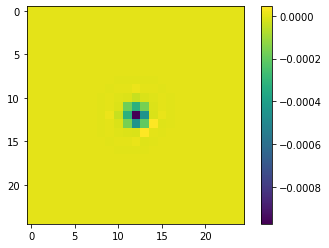

In [100]:
# Assuming c_onestep.grad is a 2D Tensor
grad_np = c_forward1_grad_sum_np

# Set the color range
vmin = grad_np.min()
vmax = grad_np.max()

plt.imshow(grad_np, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

In [101]:
print(c_forward1.grad[center_x, center_y])

tensor(-0.0010, device='cuda:0')


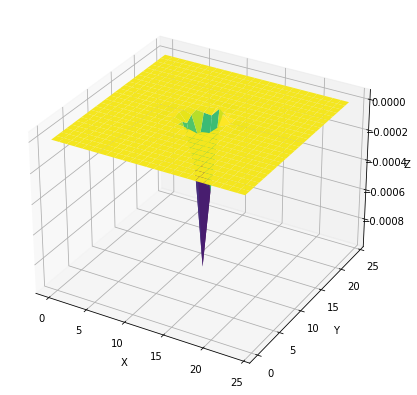

In [102]:
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of x, y values
x = np.arange(c_forward1_grad_sum_np.shape[1])
y = np.arange(c_forward1_grad_sum_np.shape[0])
x, y = np.meshgrid(x, y)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, c_forward1_grad_sum_np, cmap='viridis')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [103]:
c_forward1_grad_sum = sum(sum(c_forward1.grad))
print(c_forward1_grad_sum)

tensor(-0.0033, device='cuda:0')


In [104]:
# Initialize the loss function
mse_loss = nn.MSELoss()

In [105]:
# Initialize c_multi_new outside the loop
c_np_multi_new = np.ones((xysize, xysize)) * 1
center_x, center_y = xysize // 2, xysize // 2
c_np_multi_new[center_x, center_y] = 1.5
c_multi_new = torch.from_numpy(c_np_multi_new).float().requires_grad_().to(device)

status_t1 = status_t1.to(device).view(1, 1, xysize, xysize)
status_t0 = status_t0.to(device).view(1, 1, xysize, xysize)

# Reinitialize the model
mymodel_multi_new = AI4WaveNeuralNetwork_Multi_Skipping(xysize, filter_weight).to(device)

# Compute a numerical approximation of the gradient
c_multi_new_numerical_grad = c_multi_new.clone()
# epsilon = 1e-3
epsilon = 1.5

# output_tensor_forward1 = mymodel_multi(status_t1_tensor, status_t0_tensor, c_forward1, sigma2, nsteps = timesteps)

for i in range(c_multi_new.size(0)):
    for j in range(c_multi_new.size(1)):
        
        c_multi_new_plus = c_multi_new.clone()
        c_multi_new_plus[i, j] += epsilon
        status_tn1_plus = mymodel_multi_new(status_t1, status_t0, c_multi_new_plus, sigma2, nsteps = timesteps)
        loss_plus = mse_loss(status_tn1_plus, observational_3d_array_forward1.to(device))

        
        c_multi_new_minus = c_multi_new.clone()
        c_multi_new_minus[i, j] -= epsilon
        status_tn1_minus = mymodel_multi_new(status_t1, status_t0, c_multi_new_minus, sigma2, nsteps = timesteps)
        loss_minus = mse_loss(status_tn1_minus, observational_3d_array_forward1.to(device))
        
        c_multi_new_numerical_grad[i, j] = (loss_plus - loss_minus) / (2 * epsilon)

print(c_multi_new_numerical_grad)
print(sum(sum(c_multi_new_numerical_grad)))

/home/dg321/anaconda3/envs/icdss/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([22, 25, 25])) that is different to the input size (torch.Size([1, 22, 25, 25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  

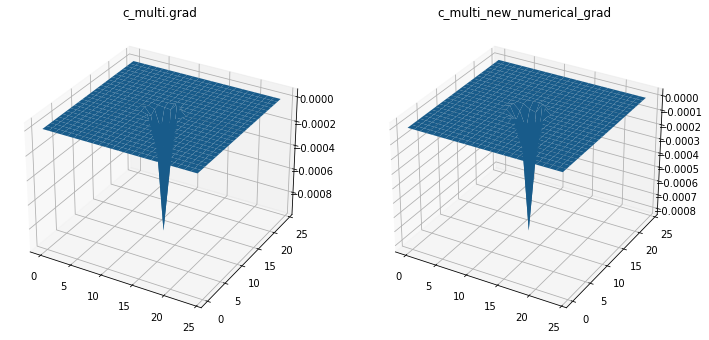

In [106]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming c_multi.grad and c_multi_new_numerical_grad are 2D Tensors
grad_np = c_forward1.grad.cpu().numpy()
new_grad_np = c_multi_new_numerical_grad.cpu().detach().numpy()

x = np.arange(grad_np.shape[1])
y = np.arange(grad_np.shape[0])
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 6))

# Plot c_multi.grad
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, grad_np)
ax1.set_title('c_multi.grad')

# Plot c_multi_new_numerical_grad
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, new_grad_np)
ax2.set_title('c_multi_new_numerical_grad')

plt.show()

In [107]:
with torch.no_grad():
    dF_over_dphi_forward2 = observational_3d_array_forward2.to(device).unsqueeze(0)

# Backward pass to calculate gradients
output_tensor_forward2.backward(dF_over_dphi_forward2)
print(c_forward2.grad)

c_forward2_grad_sum = sum(sum(c_forward2.grad))
print(c_forward2_grad_sum)

tensor([[ 2.6559e-23, -2.0379e-23, -1.4496e-21,  8.3631e-21, -2.6242e-20,
         -1.8120e-20,  2.2873e-19, -1.3364e-18,  3.4088e-18, -6.7887e-18,
          5.6986e-18, -8.3321e-18,  4.0507e-18, -3.2157e-18,  1.2280e-18,
         -1.1932e-19,  1.9407e-19, -2.4072e-20,  4.0687e-21,  4.2403e-22,
          2.1937e-23, -1.9135e-25,  1.6153e-25,  3.9590e-26,  5.0358e-27],
        [-2.0379e-23,  8.2545e-22, -3.7185e-20,  2.8588e-19, -6.1164e-19,
         -1.7310e-18,  2.3405e-17, -2.4013e-17,  2.6150e-16,  3.0807e-16,
          8.5724e-16,  7.1403e-16,  5.5782e-16,  2.9444e-16, -4.1077e-17,
          8.1037e-18,  6.2078e-18, -3.1171e-19,  4.7936e-20,  1.8957e-20,
          1.8940e-21, -8.7566e-24,  5.5363e-24,  1.5535e-24,  1.1099e-25],
        [-1.4496e-21, -3.7185e-20,  2.7957e-18, -1.7280e-17,  5.7066e-17,
          1.6585e-16, -1.2067e-15,  2.5944e-15, -1.4127e-15, -3.7007e-14,
          7.6046e-16, -9.0416e-14,  1.4284e-14, -5.3229e-14,  1.6193e-14,
         -4.8774e-15,  5.7483e-16, -

The number of zeros in the tensor is 0


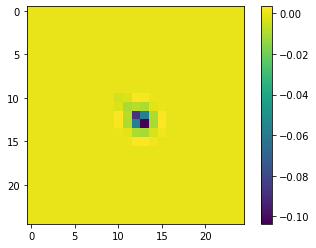

In [108]:
# Convert the tensor to a numpy array
c_forward2_grad_sum_np = c_forward2.grad.cpu().detach().numpy()

# Count the number of zeros
num_zeros = np.count_nonzero(c_forward2_grad_sum_np == 0)

print(f'The number of zeros in the tensor is {num_zeros}')

# Use imshow to visualize the array
plt.imshow(c_forward2_grad_sum_np, cmap='viridis')
plt.colorbar()
plt.show()

In [109]:
print(c_forward2.grad[center_x, center_y])

tensor(-0.0869, device='cuda:0')


In [110]:
delta_F = observational_3d_array_forward1 - observational_3d_array_forward2
print(delta_F.shape)

torch.Size([22, 25, 25])


In [111]:
delta_C = c_forward2 - c_forward1
print(delta_C.shape)
delta_C

torch.Size([25, 25])


tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000

#### Optimise C

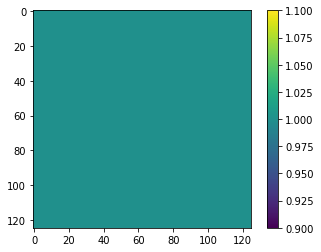

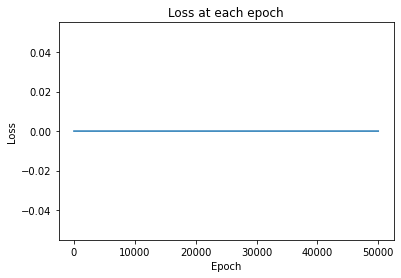

In [88]:
# Define the optimizer
optimizer = torch.optim.SGD([c], lr=0.01)

# Number of epochs
num_epochs = 50000

# Store the original c
c_np = np.ones((xysize, xysize))
# uncomment to make the values different
# right_half_start = xysize // 2
# c_np[:, right_half_start:] = 2
original_c = c_np

# List to store the losses at each epoch
losses = []

for epoch in range(num_epochs):
    optimizer.step()  # Update c using its gradient

    # Calculate and print the loss
    updated_c = c.detach().cpu().numpy()
    loss = np.mean((original_c - updated_c)**2)
    losses.append(loss)
    # print(f'Epoch {epoch}/{num_epochs}, Loss: {loss}')

    # Print progress every 10 epochs
    # if epoch % 10 == 0:
    #     plt.imshow(updated_c, cmap='viridis', interpolation='none')
    #     plt.colorbar()
    #     plt.show()

plt.imshow(updated_c, cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()


# Plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss at each epoch')
plt.show()

In [89]:
c_grad = c.grad

In [90]:
c_np = np.ones((xysize, xysize)) * 20
# uncomment to make the values different
# right_half_start = xysize // 2
# c_np[:, right_half_start:] = 2
# c = torch.from_numpy(c_np).float().requires_grad_()
# c.grad = c_grad

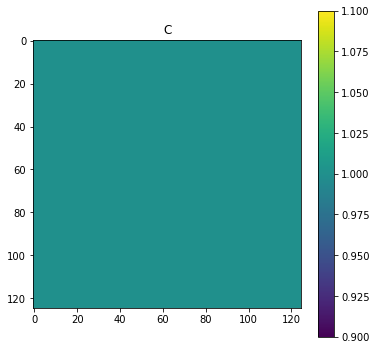

In [91]:
# Plot the tensor at t = 0
plt.figure(figsize=(6, 6))
plt.imshow(c.detach().cpu().detach().numpy(), cmap='viridis', interpolation='none')
plt.title('C')
plt.colorbar()
plt.show()

In [50]:
print(c.grad)

None


In [51]:
import torch.optim as optim

# Set up an optimizer (e.g., SGD) with a learning rate
optimizer = optim.SGD([c], lr=0.001)

num_epochs = 20000
# optimization loop
for epoch in range(num_epochs):
    # Update c using the optimizer
    optimizer.step()

    # Zero the gradients to prevent accumulation
    optimizer.zero_grad()


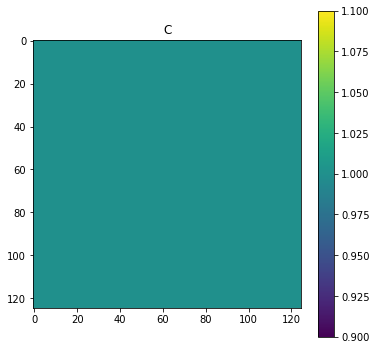

In [52]:
# Plot the tensor at t = 0
plt.figure(figsize=(6, 6))
plt.imshow(c.detach().cpu().detach().numpy(), cmap='viridis', interpolation='none')
plt.title('C')
plt.colorbar()
plt.show()

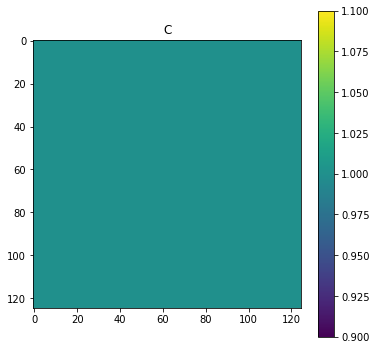

In [53]:
# Plot the tensor at t = 0
plt.figure(figsize=(6, 6))
plt.imshow(c.detach().cpu().detach().numpy(), cmap='viridis', interpolation='none')
plt.title('C')
plt.colorbar()
plt.show()